In [137]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt
import random

In [138]:
train = pd.read_csv("train.csv", index_col="PassengerId")
train_no_survived = train.drop("Survived", axis=1);

submission_dataset = pd.read_csv("test.csv") 

dataset = train_no_survived.append(submission_dataset.drop("PassengerId", axis=1))

title_list = ["Mr.", "Master.", "Mrs.", "Miss."]
    
# http://grammarist.com/usage/mr-mrs-ms-and-miss/
def map_names(name):
    for title in title_list:
        if title in name:
            return title
    return "Unknown"
            
dataset["Name"] = dataset["Name"].map(map_names)
    
def slice_and_get_mean_age_by_name(name):
    return dataset.loc[dataset["Name"] == name, "Age"].mean()
    
age_means = {k:slice_and_get_mean_age_by_name(k) for k in ["Mr.", "Master.", "Mrs.", "Miss.", "Unknown"]}

print(age_means)

def fill_age(row):
    if np.isnan(row[3]):
        row[3] = age_means[row[1]]
    return row

dataset = dataset.apply(fill_age, axis=1)

dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].mean())
dataset["Cabin"] = dataset["Cabin"].fillna("")

dataset["Embarked"] = dataset["Embarked"].fillna("Q")
dataset["Ticket"] = dataset["Ticket"].fillna("Unknown")

print(dataset.isnull().sum())

numeric_columns = ["Age", "Fare", "SibSp", "Parch"]
#cabin improves score by 0.005 might improve if we fill more cabins
categorical_columns = ["Pclass", "Embarked", "Sex", "Cabin", "Name", "Ticket"]; 

encoders = {col: LabelEncoder().fit(dataset[col]) for col in categorical_columns}

def encode_categorical(data, columns, encoders):
    return pd.DataFrame({col: encoders[col].transform(data[col]) for col in columns},
                        index = data.index)

encoded = encode_categorical(dataset, categorical_columns , encoders)

one_hot_encoder = OneHotEncoder().fit(encoded)

train_data_cleaned = dataset[0:-418]

test_data_cleaned_for_submission = dataset.tail(418)


{'Unknown': 42.65625, 'Master.': 5.4826415094339627, 'Mrs.': 36.994117647058822, 'Mr.': 32.252151462994838, 'Miss.': 21.774238095238097}
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Cabin       0
Embarked    0
dtype: int64


Master.    0.575000
Miss.      0.697802
Mr.        0.156673
Mrs.       0.792000
Unknown    0.444444
Name: Name, dtype: float64

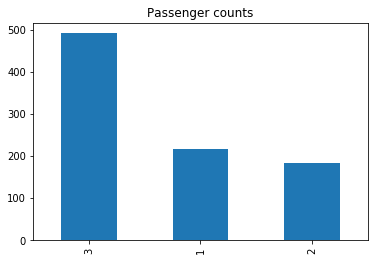

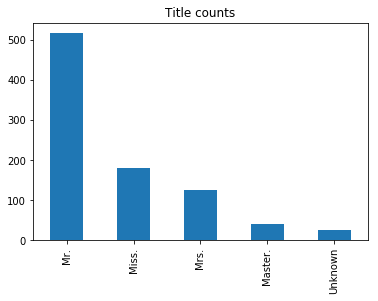

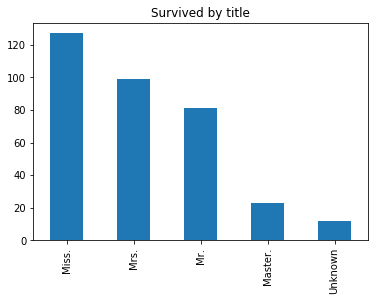

In [155]:
%matplotlib inline
plt.figure()
train_data_cleaned["Pclass"].value_counts().plot(kind="bar", title="Passenger counts")

plt.figure()
train_data_cleaned["Name"].value_counts().plot(kind="bar", title="Title counts")

plt.figure()
train_data_cleaned.loc[train["Survived"] == 1, "Name"].value_counts().plot(kind="bar", title="Survived by title")

train_data_cleaned.loc[train["Survived"] == 1, "Name"].value_counts() / train_data_cleaned["Name"].value_counts()

In [165]:
from sklearn.model_selection import train_test_split
#seems to be lucky split :(
train_X , test_X, train_y, test_y = train_test_split(train_data_cleaned, train["Survived"], random_state=26)

print(train_y.value_counts())
print(test_y.value_counts())

0    407
1    261
Name: Survived, dtype: int64
0    142
1     81
Name: Survived, dtype: int64


In [146]:
one_hot_X_train = one_hot_encoder.transform(encode_categorical(train_X[categorical_columns], categorical_columns, encoders))
one_hot_X_test = one_hot_encoder.transform(encode_categorical(test_X[categorical_columns], categorical_columns, encoders))

# train_X["Family"] = train_X["SibSp"] + train_X["Parch"]
# train_X = train_X.drop(["SibSp", "Parch"], axis=1)

# test_X["Family"] = test_X["SibSp"] + test_X["Parch"]
# test_X = test_X.drop(["SibSp", "Parch"], axis=1)

print(train_X.head(10))

print("{} {}".format(train_X[numeric_columns].shape, test_X[numeric_columns].shape))
print("{} {}".format(one_hot_X_train.shape, one_hot_X_test.shape))

train_X = np.concatenate([train_X[numeric_columns], one_hot_X_train.toarray()], axis=1);
test_X = np.concatenate([test_X[numeric_columns], one_hot_X_test.toarray()], axis=1)



print("{} {}".format(train_X.shape, test_X.shape))



     Pclass   Name     Sex        Age  SibSp  Parch        Ticket     Fare  \
536       2  Miss.  female   7.000000      0      2  F.C.C. 13529  26.2500   
691       1    Mr.    male  31.000000      1      0         17474  57.0000   
27        3    Mr.    male  32.252151      0      0          2631   7.2250   
521       1  Miss.  female  30.000000      0      0         12749  93.5000   
213       3    Mr.    male  22.000000      0      0     A/5 21174   7.2500   
497       1  Miss.  female  54.000000      1      0         36947  78.2667   
594       3  Miss.  female  21.774238      0      2        364848   7.7500   
726       3    Mr.    male  20.000000      0      0        315094   8.6625   
50        3   Mrs.  female  18.000000      1      0        349237  17.8000   
286       3    Mr.    male  33.000000      0      0        349239   8.6625   

    Cabin Embarked  
536              S  
691   B20        S  
27               C  
521   B73        S  
213              S  
497   D20      

In [141]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(C=10)
model.fit(train_X, train_y)

def print_score(train, test):
    print("Train score is {}".format(train))
    print("Test score is {}".format(test))
    print("")

print_score(model.score(train_X, train_y), model.score(test_X, test_y))

Train score is 0.9955089820359282
Test score is 0.8385650224215246



In [142]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

#tested with different n_estimators = 10 best
random_f_model = RandomForestClassifier(random_state=0)
random_f_model.fit(train_X, train_y)
print_score(random_f_model.score(train_X, train_y), random_f_model.score(test_X, test_y))

Train score is 0.9790419161676647
Test score is 0.8295964125560538



In [143]:
one_hot_test_data = one_hot_encoder.transform(encode_categorical(test_data_cleaned_for_submission[categorical_columns], categorical_columns, encoders))

# Same score as having sibsp and parch columns
# test_data_cleaned_for_submission["Family"] = test_data_cleaned_for_submission["SibSp"] +test_data_cleaned_for_submission["Parch"]
# test_data_cleaned_for_submission= test_data_cleaned_for_submission.drop(["SibSp", "Parch"], axis=1)


test_data_processed = np.concatenate([test_data_cleaned_for_submission[numeric_columns], one_hot_test_data.toarray()], axis=1);

#prediction = random_f_model.predict(test_data_processed)
prediction = model.predict(test_data_processed)

def save(prediction):
    df = pd.DataFrame(data={"Survived": prediction}, index=submission_dataset["PassengerId"])
    df.to_csv("with_data_cleaning.csv")

save(prediction)